# Finetuning Qwen2.5-VL on benthic images
The below code was used to fine-tune the models for the thesis project. The code is adapted from the notebook provided by unsloth:

https://colab.research.google.com/github/unslothai/notebooks/blob/main/nb/Qwen2.5_VL_(7B)-Vision.ipynb

Author: Aidan Murray

Date: 2025-09-26


### Installing dependancies

In [ ]:
!pip install --no-deps bitsandbytes accelerate xformers==0.0.29.post3 peft trl triton cut_cross_entropy unsloth_zoo
!pip install sentencepiece protobuf "datasets>=3.4.1" huggingface_hub hf_transfer
!pip install --no-deps unsloth

import os
os.environ['TRITON_JIT_DISABLE_OPT'] = '1' # Likely the most critical change

### Imports

In [ ]:
from unsloth import FastVisionModel
import torch
import pandas as pd
from PIL import Image
import requests
from io import BytesIO
from google.colab import drive
from unsloth.trainer import UnslothVisionDataCollator
from unsloth import get_chat_template
from trl import SFTTrainer, SFTConfig
import time
import matplotlib.pyplot as plt
from pathlib import Path

drive.mount('/content/drive')

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.


    PyTorch 2.6.0+cu124 with CUDA 1204 (you have 2.8.0+cu126)
    Python  3.12.9 (you have 3.12.11)
  Please reinstall xformers (see https://github.com/facebookresearch/xformers#installing-xformers)
  Memory-efficient attention, SwiGLU, sparse and more won't be available.
  Set XFORMERS_MORE_DETAILS=1 for more details


🦥 Unsloth Zoo will now patch everything to make training faster!
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Data Prep


In [ ]:
N = 6500      # change N to train on different size
BASE_PATH = Path("/content/drive/MyDrive/llm_finetuning")
PROMPT_PATH = BASE_PATH / "prompt.txt"

TRAIN_PARTIAL = BASE_PATH / "train_partial.csv"
VALIDATION = BASE_PATH / "validation.csv"

IMAGE_FOLDER = BASE_PATH / "all_images"

PROMPT = "Analyse the entire image carefully and decide which of the label names correspond to features that are clearly visible in the image."

df_train = pd.read_csv(TRAIN_PARTIAL).dropna(subset=['label.name'])
df_val = pd.read_csv(VALIDATION).dropna(subset=['label.name'])

In [ ]:
def create_dataset(df, folder_path, n):
    "creates a dataset in the format required to train with unsloth"

    df_indexed = df.set_index('point.media.id')
    media = df_indexed.index.to_series().drop_duplicates().sample(n=n+100, random_state=42)

    i = 0
    dataset = []
    for id in media:
        if i >= n: break

        image_path = folder_path / f"{id}.jpg"
        if not image_path.exists():
            print("Image not found, skipping path...")
            continue
        i += 1
        print(f"Getting image {i}...")
        img = Image.open(image_path)

        y_true = df_indexed.loc[id, 'label.name']

        # uncomment the context for different fine-tuning technique
        prompt_context = ""                                                                                    # basic prompt
        # prompt_context = f"\n### Context ###\n(latitude, longitude): ({latitude},{longitude})\ndepth: {depth}" # numical context
        # prompt_context = f"\n### Context ###\nRealm: {realm}\nProvince: {province}\nEcoregion: {ecoregion}"    # hierarchical
        # prompt_context = f"\n### Context ###\nEcoregion: {ecoregion}"                                          # ecoregions only

        new_prompt = PROMPT + prompt_context

        conversation = [
            { "role": "user",
              "content" : [
                {"type" : "text",  "text"  : new_prompt},
                {"type" : "image", "image" : img} ]
            },
            { "role" : "assistant",
              "content" : [
                {"type" : "text",  "text"  : y_true} ]
            },
        ]
        messages = { "messages" : conversation }

        dataset.append(messages)

    print(f"Finished. Successfully downloaded {i} images and their annotations")
    return dataset

In [ ]:
train_dataset = create_dataset(df_train, IMAGE_FOLDER, N)

Streaming output truncated to the last 5000 lines.
Getting image 206...
Getting image 207...
Getting image 208...
Getting image 209...
Getting image 210...
Getting image 211...
Getting image 212...
Getting image 213...
Getting image 214...
Getting image 215...
Getting image 216...
Getting image 217...
Getting image 218...
Getting image 219...
Getting image 220...
Getting image 221...
Getting image 222...
Getting image 223...
Getting image 224...
Getting image 225...
Getting image 226...
Getting image 227...
Getting image 228...
Getting image 229...
Getting image 230...
Getting image 231...
Getting image 232...
Getting image 233...
Getting image 234...
Getting image 235...
Getting image 236...
Getting image 237...
Getting image 238...
Getting image 239...
Getting image 240...
Getting image 241...
Getting image 242...
Getting image 243...
Getting image 244...
Getting image 245...
Getting image 246...
Getting image 247...
Getting image 248...
Getting image 249...
Getting image 250...
Gett

In [ ]:
val_dataset = create_dataset(df_val, IMAGE_FOLDER, 300)

Getting image 1...
Getting image 2...
Getting image 3...
Getting image 4...
Getting image 5...
Getting image 6...
Getting image 7...
Getting image 8...
Getting image 9...
Getting image 10...
Getting image 11...
Getting image 12...
Getting image 13...
Getting image 14...
Getting image 15...
Getting image 16...
Getting image 17...
Getting image 18...
Getting image 19...
Getting image 20...
Getting image 21...
Getting image 22...
Getting image 23...
Getting image 24...
Getting image 25...
Getting image 26...
Getting image 27...
Getting image 28...
Getting image 29...
Getting image 30...
Getting image 31...
Getting image 32...
Getting image 33...
Getting image 34...
Getting image 35...
Getting image 36...
Getting image 37...
Getting image 38...
Getting image 39...
Getting image 40...
Getting image 41...
Getting image 42...
Getting image 43...
Getting image 44...
Getting image 45...
Getting image 46...
Getting image 47...
Getting image 48...
Getting image 49...
Getting image 50...
Getting i

### Prepare model with unsloth

In [ ]:
model_name = "unsloth/Qwen2.5-VL-3B-Instruct-bnb-4bit"
# model_name = "unsloth/Qwen2.5-VL-7B-Instruct-bnb-4bit"

model, tokenizer = FastVisionModel.from_pretrained(
    model_name,
    load_in_4bit = False,
    use_gradient_checkpointing = False,
)

model = FastVisionModel.get_peft_model(
    model,
    finetune_vision_layers     = True, # False if not finetuning vision layers
    finetune_language_layers   = True, # False if not finetuning language layers
    finetune_attention_modules = True, # False if not finetuning attention layers
    finetune_mlp_modules       = True, # False if not finetuning MLP layers

    r = 16,           # The larger, the higher the accuracy, but might overfit
    lora_alpha = 16,  # Recommended alpha == r at least
    lora_dropout = 0,
    bias = "none",
    random_state = 3407,
    use_rslora = False,  # We support rank stabilized LoRA
    loftq_config = None, # And LoftQ
)

==((====))==  Unsloth 2025.8.9: Fast Qwen2_5_Vl patching. Transformers: 4.55.2.
   \\   /|    NVIDIA L4. Num GPUs = 1. Max memory: 22.161 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.8.0+cu126. CUDA: 8.9. CUDA Toolkit: 12.6. Triton: 3.4.0
\        /    Bfloat16 = TRUE. FA [Xformers = None. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!
Unsloth: QLoRA and full finetuning all not selected. Switching to 16bit LoRA.


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

The image processor of type `Qwen2VLImageProcessor` is now loaded as a fast processor by default, even if the model checkpoint was saved with a slow processor. This is a breaking change and may produce slightly different outputs. To continue using the slow processor, instantiate this class with `use_fast=False`. Note that this behavior will be extended to all models in a future release.
You have video processor config saved in `preprocessor.json` file which is deprecated. Video processor configs should be saved in their own `video_preprocessor.json` file. You can rename the file or load and save the processor back which renames it automatically. Loading from `preprocessor.json` will be removed in v5.0.


### Train the model

In [ ]:
from unsloth.trainer import UnslothVisionDataCollator
from trl import SFTTrainer, SFTConfig

FastVisionModel.for_training(model) # Enable for training!

trainer = SFTTrainer(
    model = model,
    tokenizer = tokenizer,
    data_collator = UnslothVisionDataCollator(model, tokenizer), # Must use!
    train_dataset = train_dataset,
    eval_dataset = val_dataset,
    max_seq_length = 4096,
    # eval_strategy = "steps",

    args = SFTConfig(
        per_device_train_batch_size = 8,
        gradient_accumulation_steps = 4,
        warmup_steps = 5,
        # max_steps = 80,
        num_train_epochs = 1, # Set this instead of max_steps for full training runs
        learning_rate = 2e-4,
        logging_steps = 1,
        optim = "adamw_8bit",
        weight_decay = 0.01,
        lr_scheduler_type = "linear",
        seed = 3407,
        output_dir = "outputs",
        report_to = "none",     # For Weights and Biases

        # You MUST put the below items for vision finetuning:
        remove_unused_columns = False,
        dataset_text_field = "",
        dataset_kwargs = {"skip_prepare_dataset": True},
        dataset_num_proc = 4,

        eval_strategy = "steps",
        eval_steps = 10,


        assistant_only_loss = True,
    ),
)

Unsloth: Model does not have a default image size - using 512


In [ ]:
# @title Show current memory stats
gpu_stats = torch.cuda.get_device_properties(0)
start_gpu_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
max_memory = round(gpu_stats.total_memory / 1024 / 1024 / 1024, 3)
print(f"GPU = {gpu_stats.name}. Max memory = {max_memory} GB.")
print(f"{start_gpu_memory} GB of memory reserved.")

GPU = NVIDIA L4. Max memory = 22.161 GB.
15.709 GB of memory reserved.


In [ ]:
trainer_stats = trainer.train()

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 5,200 | Num Epochs = 1 | Total steps = 163
O^O/ \_/ \    Batch size per device = 8 | Gradient accumulation steps = 4
\        /    Data Parallel GPUs = 1 | Total batch size (8 x 4 x 1) = 32
 "-____-"     Trainable parameters = 51,521,536 of 8,343,688,192 (0.62% trained)


Step,Training Loss,Validation Loss
10,2.227600,1.946910
20,0.875000,0.734234
30,0.381000,0.367171
40,0.182900,0.199681
50,0.153600,0.155889
60,0.126200,0.135715
70,0.104500,0.125697
80,0.102000,0.118680
90,0.101900,0.111497
100,0.136700,0.107930


Unsloth: Not an error, but Qwen2_5_VLForConditionalGeneration does not accept `num_items_in_batch`.
Using gradient accumulation will be very slightly less accurate.
Read more on gradient accumulation issues here: https://unsloth.ai/blog/gradient


In [ ]:
# @title Show final memory and time stats
used_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
used_memory_for_lora = round(used_memory - start_gpu_memory, 3)
used_percentage = round(used_memory / max_memory * 100, 3)
lora_percentage = round(used_memory_for_lora / max_memory * 100, 3)
print(f"{trainer_stats.metrics['train_runtime']} seconds used for training.")
print(
    f"{round(trainer_stats.metrics['train_runtime']/60, 2)} minutes used for training."
)
print(f"Peak reserved memory = {used_memory} GB.")
print(f"Peak reserved memory for training = {used_memory_for_lora} GB.")
print(f"Peak reserved memory % of max memory = {used_percentage} %.")
print(f"Peak reserved memory for training % of max memory = {lora_percentage} %.")

3610.3792 seconds used for training.
60.17 minutes used for training.
Peak reserved memory = 18.652 GB.
Peak reserved memory for training = 2.943 GB.
Peak reserved memory % of max memory = 84.166 %.
Peak reserved memory for training % of max memory = 13.28 %.


## Show effect of epochs

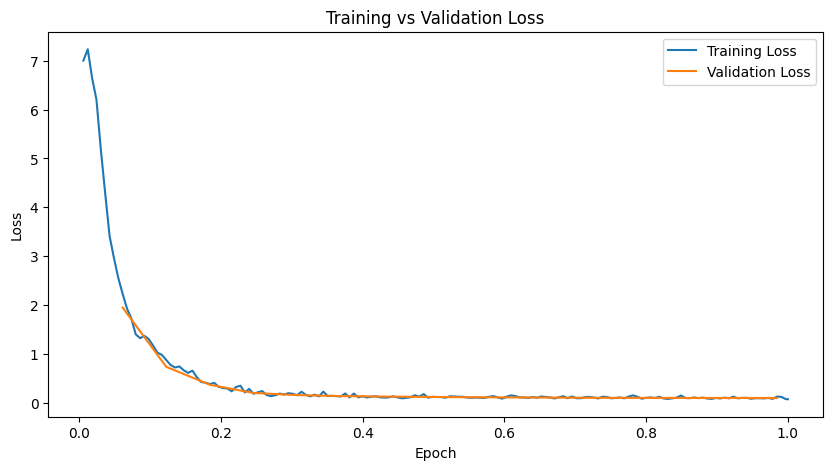

In [ ]:
log_history = trainer.state.log_history

train_losses = []
train_epochs = []
eval_losses = []
eval_epochs = []

for entry in log_history:
    if 'loss' in entry and 'eval_loss' not in entry:
        train_losses.append(entry['loss'])
        train_epochs.append(entry['epoch'])
    elif 'eval_loss' in entry:
        eval_losses.append(entry['eval_loss'])
        eval_epochs.append(entry['epoch'])

plt.figure(figsize=(10, 5))
plt.plot(train_epochs[:len(train_losses)], train_losses, label="Training Loss")
plt.plot(eval_epochs[:len(eval_losses)], eval_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.show()

## Check the output after training

('Sand', 'Turfing algae (<2 cm high algal/sediment mat on rock)')


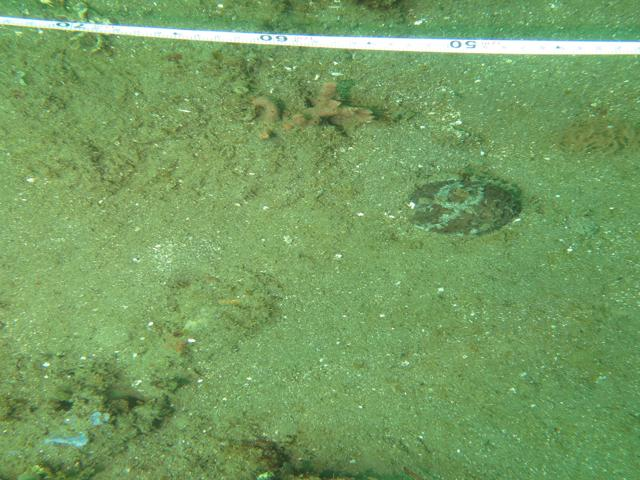

In [ ]:
img = val_dataset[0]['messages'][0]['content'][1]['image']

print(val_dataset[0]['messages'][1]['content'][0]['text'])
img

In [ ]:
FastVisionModel.for_inference(model) # Enable for inference!

image = img
instruction = PROMPT

messages = [
    {"role": "user", "content": [
        {"type": "image"},
        {"type": "text", "text": instruction}
    ]}
]

input_text = tokenizer.apply_chat_template(messages, add_generation_prompt = True)

inputs = tokenizer(
    image,
    input_text,
    add_special_tokens = False,
    return_tensors = "pt",
).to("cuda")

from transformers import TextStreamer

text_streamer = TextStreamer(tokenizer, skip_prompt = True)

_ = model.generate(**inputs, streamer = text_streamer, max_new_tokens = 1028,
                   use_cache = True, temperature = 1.0, min_p = 0.1)

('Barnacles', 'Sand')<|im_end|>


# Save the Model to huggingface

In [ ]:
if True: model.push_to_hub_merged("username/model-name", tokenizer, token = "token")

Processing Files (0 / 0)                : |          |  0.00B /  0.00B            

New Data Upload                         : |          |  0.00B /  0.00B            

  ...RA-qwen2.5VL-7B-5200/tokenizer.json: 100%|##########| 11.4MB / 11.4MB            

Found HuggingFace hub cache directory: /root/.cache/huggingface/hub
Checking cache directory for required files...
Successfully copied all 4 files from cache to aidan-ucc/LoRA-qwen2.5VL-7B-5200.


Unsloth: Merging weights into 16bit:   0%|          | 0/4 [00:00<?, ?it/s]

Processing Files (0 / 0)                : |          |  0.00B /  0.00B            

New Data Upload                         : |          |  0.00B /  0.00B            

  ...00/model-00001-of-00004.safetensors:   1%|          | 41.9MB / 4.97GB            

Unsloth: Merging weights into 16bit:  25%|██▌       | 1/4 [01:39<04:57, 99.14s/it]

Processing Files (0 / 0)                : |          |  0.00B /  0.00B            

New Data Upload                         : |          |  0.00B /  0.00B            

  ...00/model-00002-of-00004.safetensors:   0%|          |  608kB / 4.99GB            

Unsloth: Merging weights into 16bit:  50%|█████     | 2/4 [04:08<04:16, 128.40s/it]

Processing Files (0 / 0)                : |          |  0.00B /  0.00B            

New Data Upload                         : |          |  0.00B /  0.00B            

  ...00/model-00003-of-00004.safetensors:   0%|          |  608kB / 4.93GB            

Unsloth: Merging weights into 16bit:  75%|███████▌  | 3/4 [06:14<02:07, 127.68s/it]

Processing Files (0 / 0)                : |          |  0.00B /  0.00B            

New Data Upload                         : |          |  0.00B /  0.00B            

  ...00/model-00004-of-00004.safetensors:   2%|2         | 41.9MB / 1.69GB            

Unsloth: Merging weights into 16bit: 100%|██████████| 4/4 [06:58<00:00, 104.68s/it]
